In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost
import shap

In [2]:
# ONLY USE IF DATASET IS AVAILABLE
df_stats = pd.read_csv('dataset_new_clean.csv',sep=";")

# Read Data

In [ ]:
df = pd.read_pickle('../clean/inactive_list_cleaned.p')
df = df.reset_index()
df = df.drop(columns=['index'],axis=1)
df['Season']=pd.DatetimeIndex(df['Date']).year
df['Month']=pd.DatetimeIndex(df['Date']).month
df.head()

In [ ]:
df_stats = pd.read_pickle('../clean/player_stats_cleaned.p')
df_stats = df_stats.reset_index()
df_stats = df_stats.drop(columns=['index'], axis=1)
df_stats['target'] = 0
df_stats = df_stats[df_stats['Year'] > 2014] # 2015

def label_target():
    for i,r in df_stats.iterrows():
        on_il = np.sum(df[(df.Player==r.Player) & (df.Season == r.Year)]['on_IL'])
        df_stats.at[i,'target'] = int(on_il>0)

label_target()

In [ ]:
df_stats.head()

In [ ]:
df_stats.describe()

In [ ]:
df_stats_clean = df_stats.drop(columns=[
    'Player',
    'Season',
    'Team',
    'PLAYER_ID',
    'Year'],axis=1)
df_stats_clean = df_stats_clean.dropna()
df_stats_clean.head()

In [ ]:
df_stats_clean.to_csv('dataset_new_clean.csv',sep=';',index=False)

# EDA

In [ ]:
# 61% of injuries, 39% of non-injuries
100*(df_stats['target'].value_counts().values/df_stats.shape[0])

In [ ]:
plt.figure()
sns.heatmap(df_stats.corr())

In [ ]:
plt.figure()
df_stats[list(df_stats.columns)[:5]].plot(kind='hist', subplots=True)
plt.show()

## Feature Engineering

For feature engineering we create an additional feature which is the playstyle of a player. This is done with a clustering algorithms to group observations by playstyle. The features used for clustering are:

* `BOX_OUTS`
* `DEFLECTIONS`
* `REB`
* `DIST_MILES`
* `AVG_SPEED`
* `BLK`
* `PF`
* `PFD`

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, QuantileTransformer

playstyle_ft = ['BOX_OUTS','DEFLECTIONS','REB','DIST_MILES','AVG_SPEED','BLK','PF','PFD']

data_cluster = df_stats[playstyle_ft]

# standardize
scaler = StandardScaler()
scaler = scaler.fit(data_cluster)
data_cluster = pd.DataFrame(data=scaler.transform(data_cluster), columns=playstyle_ft)

clf = KMeans(3, init='random', random_state=42).fit(data_cluster)

df_stats_fe = df_stats.copy()
target = df_stats_fe.pop('target')
df_stats_fe['PLAYSTYLE']=clf.predict(data_cluster)
df_stats_fe['target'] = target

df_stats_fe_v2 = df_stats_fe.copy()
df_stats_fe_v2 = df_stats_fe_v2.drop(playstyle_ft, axis=1)

df_stats_qnt = df_stats.copy()

f = 1
qt = QuantileTransformer(n_quantiles=max(min(df_stats_qnt.shape[0] // 25, 1000), 10),output_distribution="normal",random_state=42)

df_stats_qnt[qt.get_feature_names_out()] = qt.fit_transform(df_stats_qnt.drop(['target'], axis=1))

Text(0.5, 0, "['BOX_OUTS', 'DEFLECTIONS', 'REB', 'DIST_MILES', 'AVG_SPEED', 'BLK', 'PF', 'PFD']")

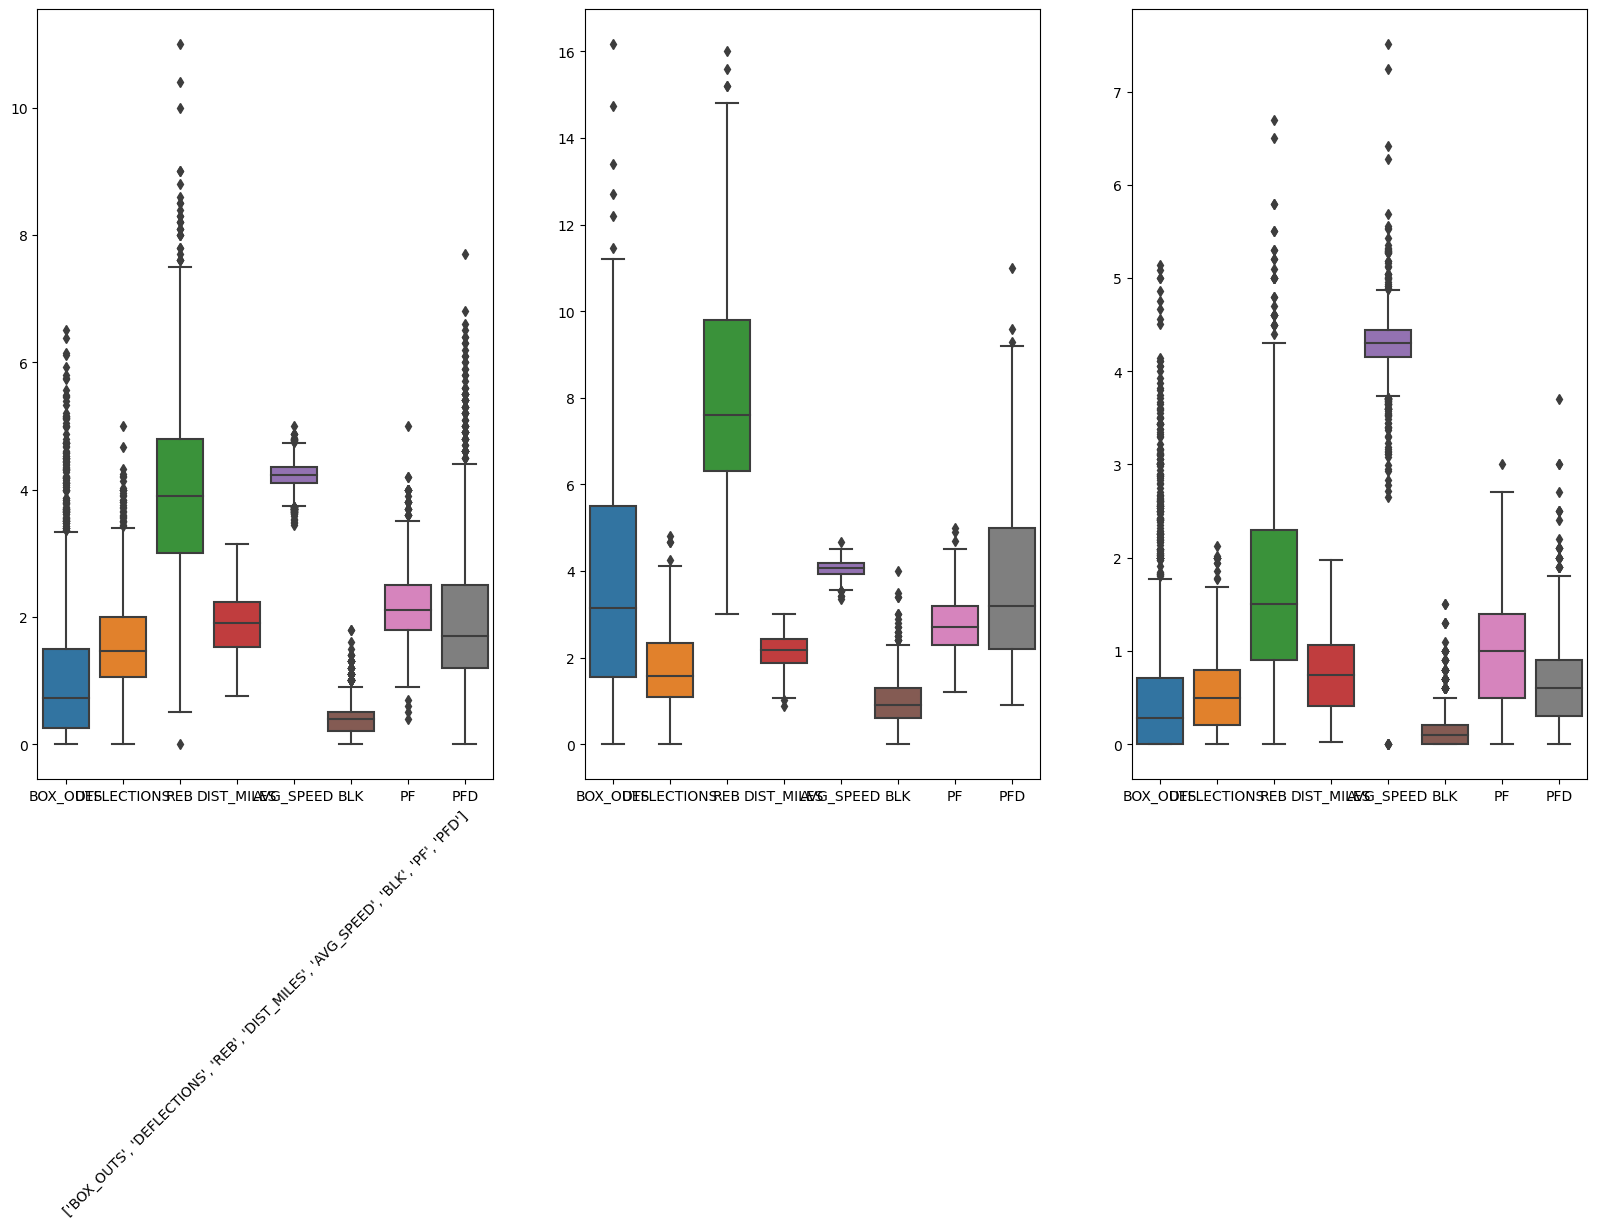

In [47]:
fig, axs = plt.subplots(1,3, figsize=(20,10))

sns.boxplot(data=df_stats_fe[df_stats_fe['PLAYSTYLE']==0][playstyle_ft],ax=axs[0])
sns.boxplot(data=df_stats_fe[df_stats_fe['PLAYSTYLE']==1][playstyle_ft],ax=axs[1])
sns.boxplot(data=df_stats_fe[df_stats_fe['PLAYSTYLE']==2][playstyle_ft],ax=axs[2])

axs[0].set_xlabel(playstyle_ft, rotation=45)

In [ ]:
plt.figure()
df_stats_qnt[list(df_stats_qnt.columns)[:5]].plot(kind='hist', subplots=True)
plt.show()

In [4]:
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
new_ft = est.fit_transform(df_stats_fe_v2.iloc[:,4:-1])

df_stats_sparse = df_stats_fe_v2.copy()
df_stats_sparse.iloc[:,4:-1] = new_ft

Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 12 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 13 are removed. Consider decreasing the number of bins.


# Experiments

In [12]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as score

ss = {
    'n_estimators': [50,75,100],
    'max_depth': np.arange(2,5,1),
    'booster': ['gbtree','dart'],
    'learning_rate': [0.1,0.5,1],
    'objective': ["binary:logistic"]
}

def split(data, size):
    X = data.drop(columns=['target'],axis=1)
    y = data['target'].values

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=size, random_state=42)

    return X_train, X_test, y_train, y_test

def train(X,y, params):
    
    model = xgboost.XGBClassifier()

    search = GridSearchCV(model, params, scoring='accuracy')#RandomizedSearchCV(model, params, n_iter=30, scoring='accuracy', random_state=42)

    res = search.fit(X,y)

    return res

## Experiment 1. Different Feature Engineering and Hyper parameterization

In [13]:
datasets = {
    'Raw': df_stats,
    'W/ FE': df_stats_fe,
    'W/ FE v2': df_stats_fe_v2,
    'W/ Qt': df_stats_qnt,
    'Sparse': df_stats_sparse
}

scores = {}

for d in datasets:

    X_train, X_test, y_train, y_test = split(datasets.get(d),0.2)

    res = train(X_train, y_train, ss)

    scores[d] = {
        "best_params": res.best_params_,
        "val_best": res.best_score_,
        "val_best_std": res.cv_results_["std_test_score"][res.best_index_],
        "val": res.cv_results_['mean_test_score'],
    }

    pred = res.predict(X_test)

    scores[d]["test"] = score(y_test, pred)

    print(f'\nDataset: {d}\n---')
    print(f'  val: {np.round(scores[d]["val_best"],4)} +\- {np.round(scores[d]["val_best_std"],4)}')
    print(f'  test: {np.round(scores[d]["test"],4)}')



Dataset: Raw
---
  val: 0.6732 +\- 0.009
  test: 0.6531

Dataset: W/ FE
---
  val: 0.6729 +\- 0.0113
  test: 0.6509

Dataset: W/ FE v2
---
  val: 0.6746 +\- 0.0091
  test: 0.6619

Dataset: W/ Qt
---
  val: 0.6726 +\- 0.0099
  test: 0.6531

Dataset: Sparse
---
  val: 0.6795 +\- 0.006
  test: 0.652


When using discretize data we actually end up with better results at the cost of interpretability. Features do not make as much sense because they have discretized into buckets

In [14]:
best_params = scores['W/ FE v2']['best_params']

Text(0.5, 0, 'Iterations')

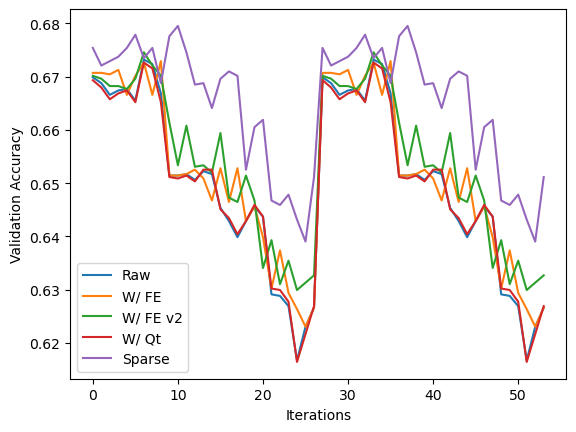

In [15]:
for d in scores:
    plt.plot(scores.get(d)["val"], label=f'{d}')

plt.legend()
plt.ylabel('Validation Accuracy')
plt.xlabel('Iterations')

## Experiment .2 - Understanding Features

In [16]:
best_params

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 50,
 'objective': 'binary:logistic'}

In [17]:
X_train, X_test, y_train, y_test = split(datasets.get('W/ FE v2'),0.2)

In [18]:
clf = xgboost.XGBClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    booster = best_params['booster'],
    objetive = best_params['objective']
)

clf = clf.fit(X_train, y_train)
ft_imp = clf.feature_importances_

[20:30:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "objetive" } are not used.



In [19]:
ranking = np.argsort(np.abs(ft_imp))
res = [{} for i in range(len(ft_imp))]

for i in range(len(ft_imp)):
    n = len(ft_imp) - i
    idx = ranking[:n].copy()
    np.random.shuffle(idx)

    clf = xgboost.XGBClassifier(
        n_estimators = best_params['n_estimators'],
        max_depth = best_params['max_depth'],
        learning_rate = best_params['learning_rate'],
        booster = best_params['booster'],
        objective = best_params['objective'],
        random_state=42
    )
    
    clf = clf.fit(X_train.iloc[:,idx], y_train)
    pred = clf.predict(X_test.iloc[:, idx])
    res[i] = {
        "acc": score(y_test, pred),
        "size": np.round(n/len(ft_imp),2),
        "features": idx
    }

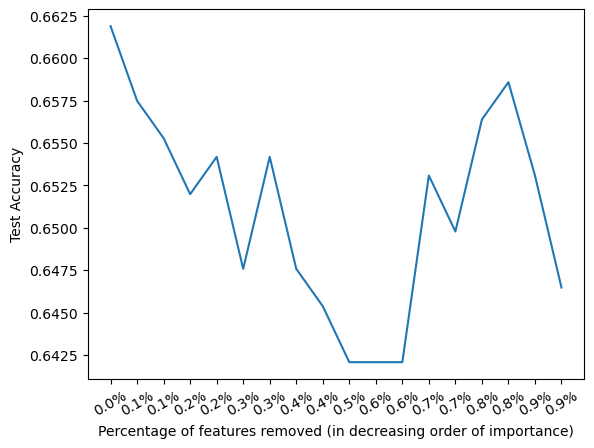

{'acc': 0.6618942731277533, 'size': 1.0, 'features': array([ 0,  9, 16,  7, 12, 14,  2, 17, 15,  5, 10,  3,  8,  1,  4, 13, 11,
        6], dtype=int64)}
Best ['Age', 'AVG_SPEED_OFF', 'CHARGES_DRAWN', 'DIST_MILES_OFF', 'CONTESTED_SHOTS_2PT', 'OFF_BOXOUTS', 'Weight', 'PLAYSTYLE', 'DEF_BOXOUTS', 'OREB', 'AVG_SPEED_DEF', 'GP', 'DIST_MILES_DEF', 'Inches', 'MIN', 'CONTESTED_SHOTS_3PT', 'CONTESTED_SHOTS', 'DREB']


In [20]:
plt.plot(np.arange(0,len(res)),[r['acc'] for r in res])
plt.xticks(np.arange(len(res)),[f"{np.round(1-r['size'],1)}%" for r in res],rotation=30)
plt.ylabel('Test Accuracy')
plt.xlabel(f'Percentage of features removed (in decreasing order of importance)')
plt.show()

best = res[np.argmax([r['acc'] for r in res])]
print(best)

best_ft = list(X_train.columns[best['features']])
print(f'Best {best_ft}')

In [25]:
ranking = np.argsort(np.abs(ft_imp))[::-1]
res = [{} for i in range(len(ft_imp))]

for i in range(len(ft_imp)):
    n = len(ft_imp) - i
    idx = ranking[:n].copy()
    np.random.shuffle(idx)

    clf = xgboost.XGBClassifier(
        n_estimators = best_params['n_estimators'],
        max_depth = best_params['max_depth'],
        learning_rate = best_params['learning_rate'],
        booster = best_params['booster'],
        objective = best_params['objective'],
        random_state=42
    )
    
    clf = clf.fit(X_train.iloc[:,idx], y_train)
    pred = clf.predict(X_test.iloc[:, idx])
    res[i] = {
        "acc": score(y_test, pred),
        "size": np.round(n/len(ft_imp),2),
        "features": idx
    }

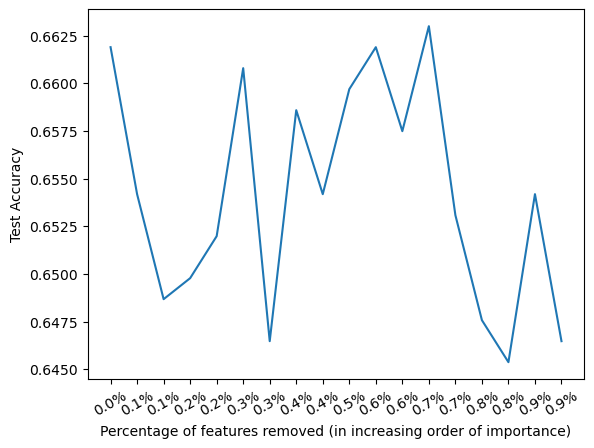

{'acc': 0.6629955947136564, 'size': 0.33, 'features': array([ 3, 14,  6,  0, 17,  4], dtype=int64)}
Best ['GP', 'OFF_BOXOUTS', 'DREB', 'Age', 'PLAYSTYLE', 'MIN']


In [26]:
plt.plot(np.arange(0,len(res)),[r['acc'] for r in res])
plt.xticks(np.arange(len(res)),[f"{np.round(1-r['size'],1)}%" for r in res],rotation=30)
plt.ylabel('Test Accuracy')
plt.xlabel(f'Percentage of features removed (in increasing order of importance)')
plt.show()

best = res[np.argmax([r['acc'] for r in res])]
print(best)

best_ft = list(X_train.columns[best['features']])
print(f'Best {best_ft}')

## Experiment 3

In [28]:
clf = xgboost.XGBClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    booster = best_params['booster'],
    objective='binary:logistic',
    random_state=42
)

clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score(y_test, pred)

0.6618942731277533

In [29]:
clf_base = xgboost.XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

clf_base = clf_base.fit(X_train, y_train)
pred = clf_base.predict(X_test)
score(y_test, pred)

0.6299559471365639

In [32]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree = clf_tree.fit(X_train,y_train)
pred = clf_tree.predict(X_test)
score(y_test, pred)

0.552863436123348

In [33]:
from sklearn.svm import SVC

clf_svm = SVC(random_state=42)
clf_svm = clf_svm.fit(X_train, y_train)
pred = clf_svm.predict(X_test)
score(y_test, pred)

0.6464757709251101

In [35]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=42)
clf_rf = clf_rf.fit(X_train, y_train)
pred = clf_rf.predict(X_test)
score(y_test, pred)

0.6497797356828194

## Explanations

In [36]:
shap.initjs()

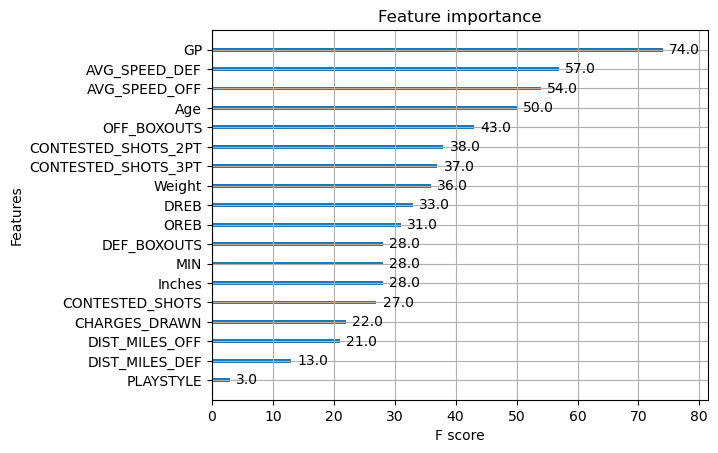

In [37]:
xgboost.plot_importance(clf)
plt.show()

In [39]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)

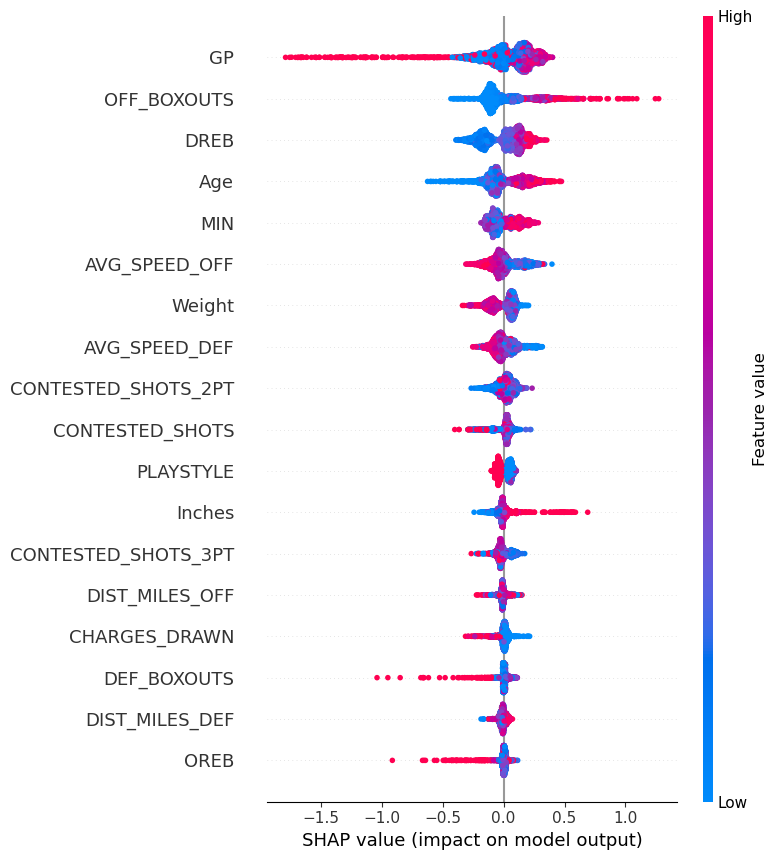

<Figure size 640x480 with 0 Axes>

In [43]:
shap.summary_plot(shap_values, X_train)
plt.savefig('figs/global.png')

* High values of the `GP` feature have a high negative contribution on the prediction (drive the model to predict non-injury) and a slightly high positive contribution. A low number of games has little bearing on the output of the model.
* More `OFF_BOXOUTS`, `MIN`, `DREB`,`Age` and `Inches` more likely the model is to drive the prediction to injury, and vice-verse.
* `PLAYSTYLE` has neglegible effect on predictions

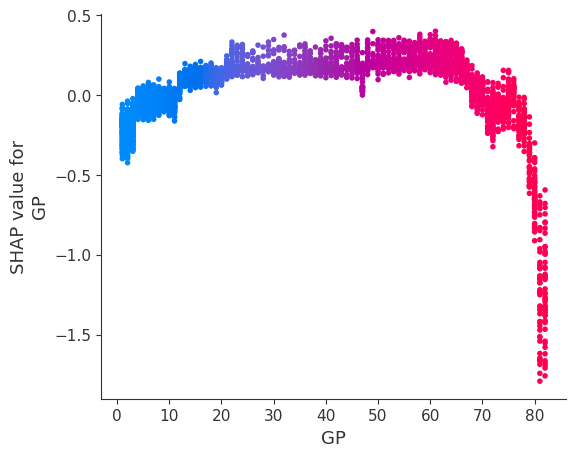

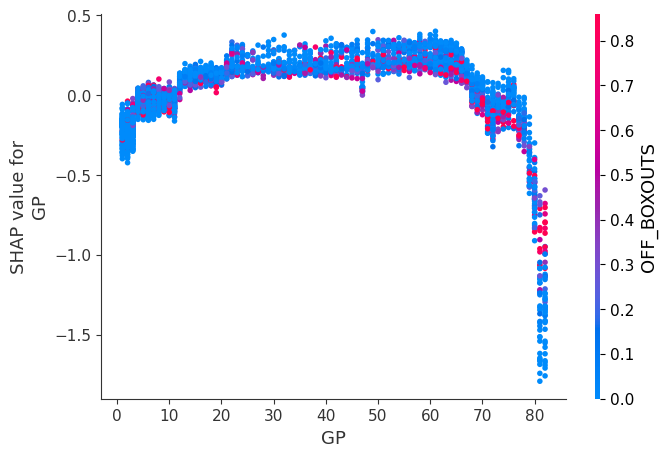

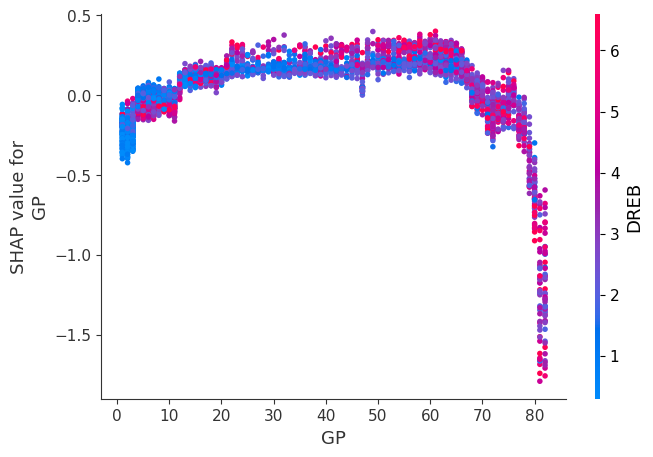

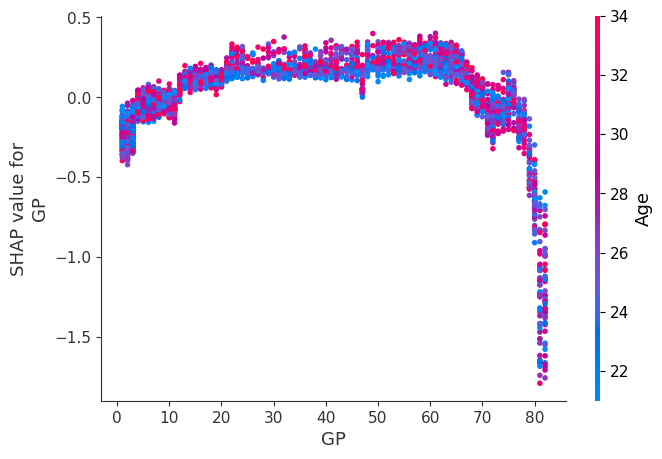

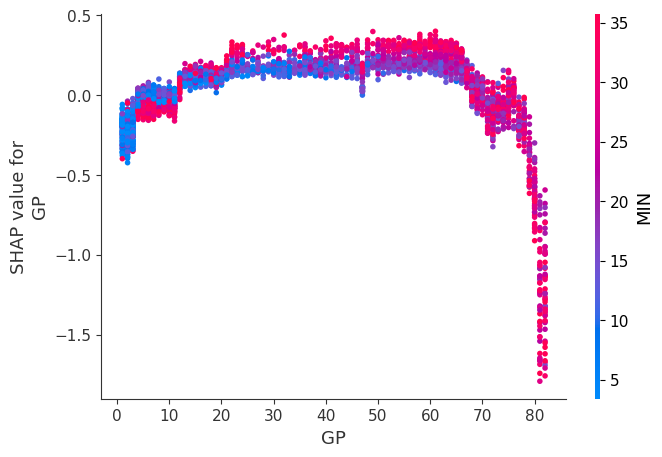

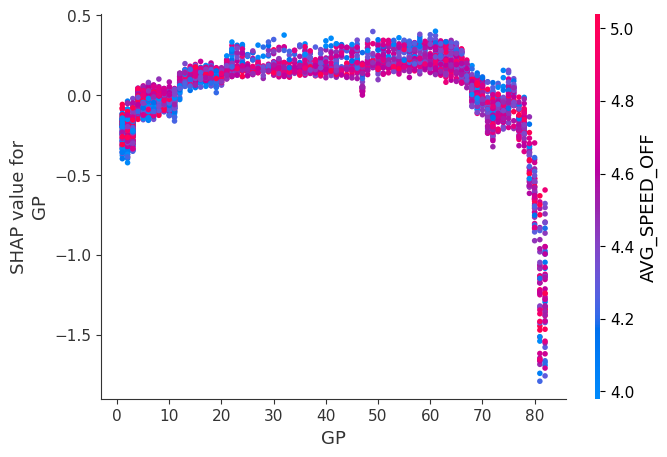

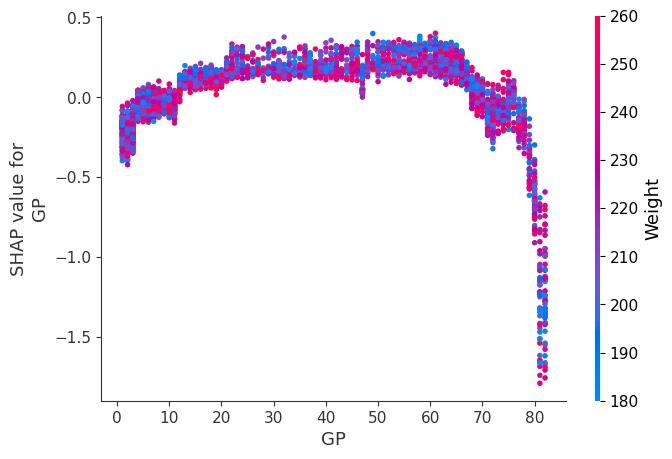

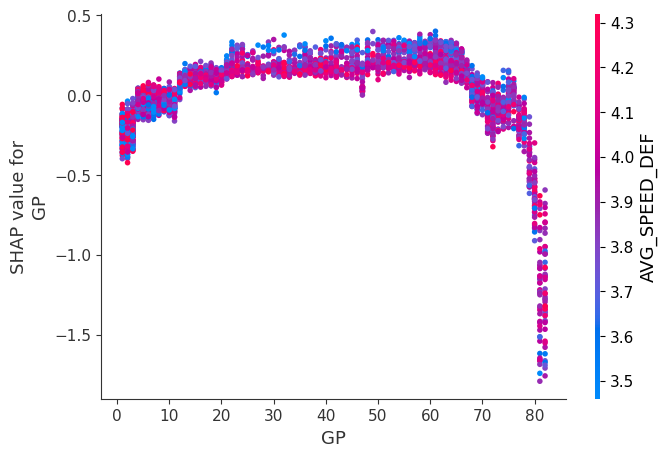

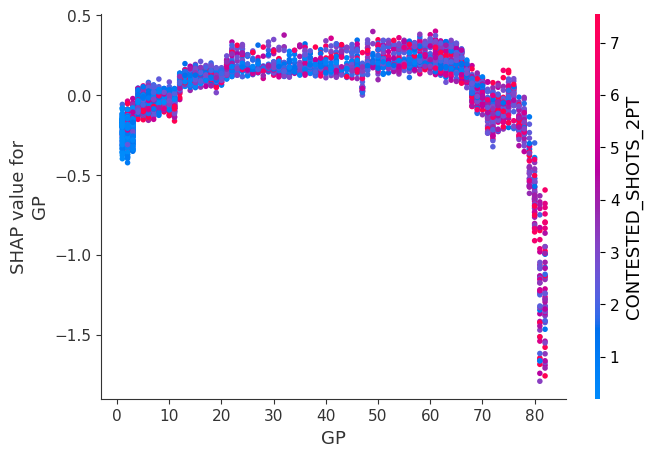

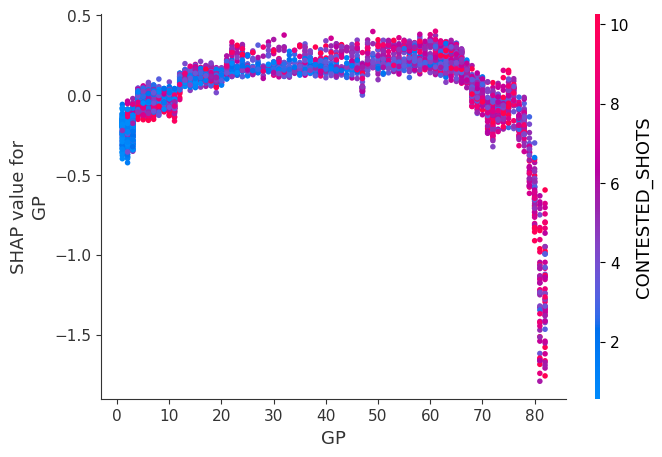

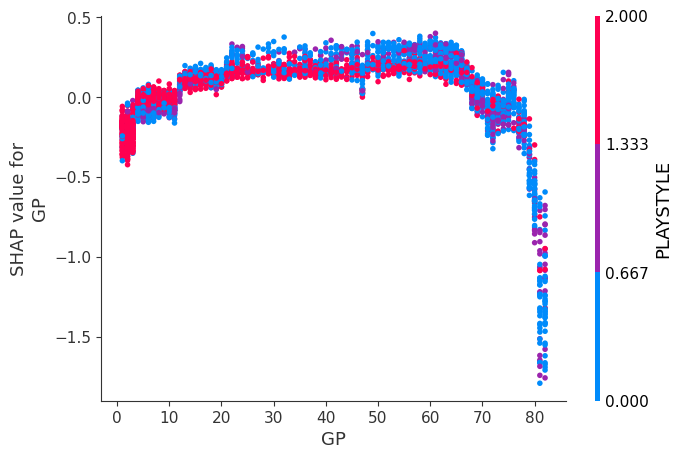

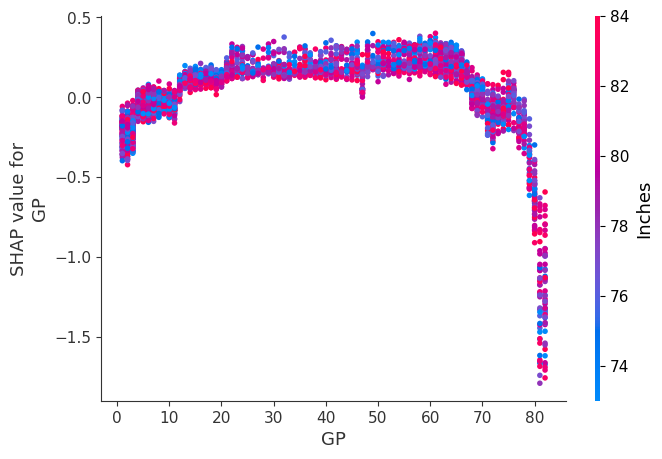

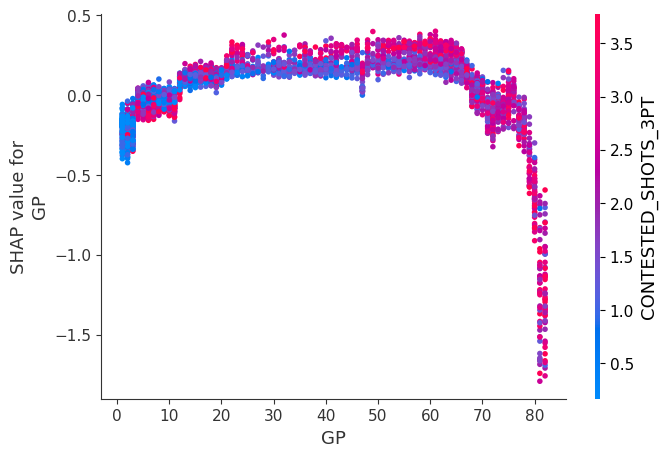

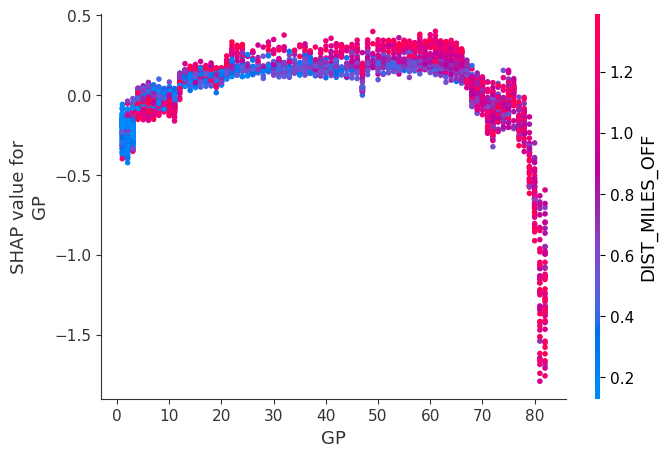

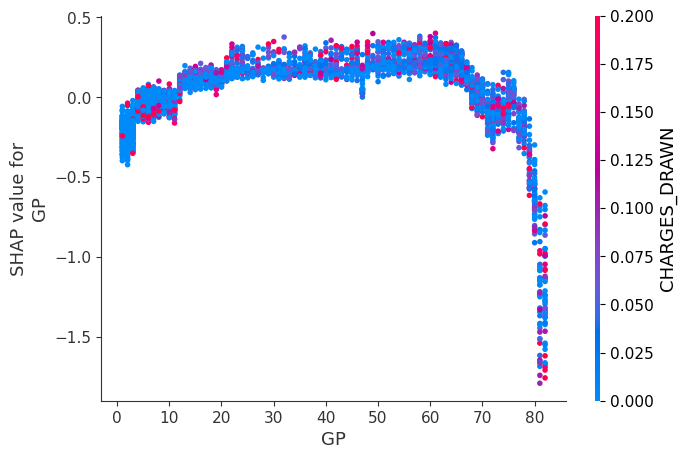

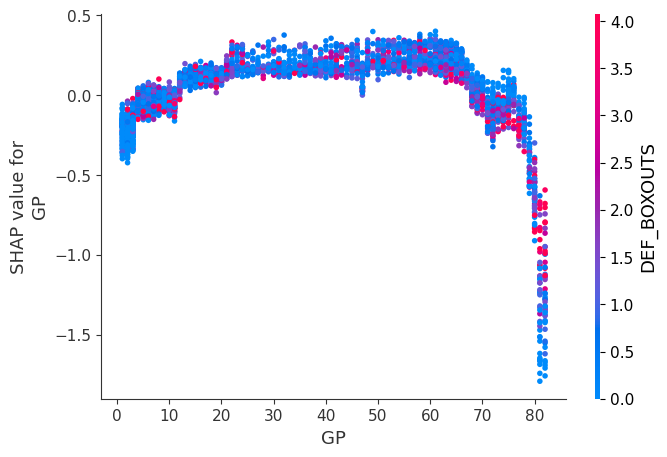

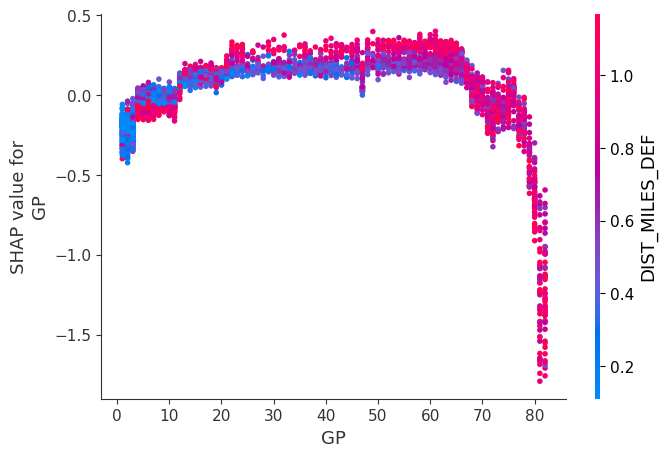

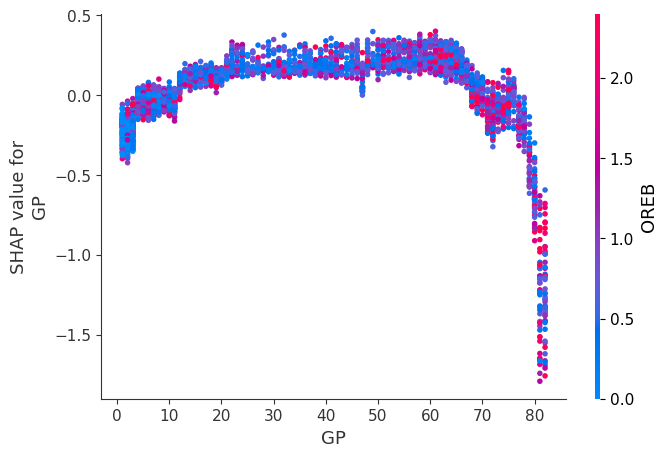

In [50]:
inds = np.argsort(-np.sum(np.abs(shap_values.values), 0))
for f in inds:
    shap.dependence_plot("GP", shap_values.values, X_train, interaction_index=X_train.columns[f])

*

In [56]:
shap.plots.force(shap_values[0])